# Object Detection for Cup Cropping

이 노트북에서는 Object Detection 모델을 사용하여 이미지에서 컵 영역을 감지하고 cropping합니다.

## 목표
- YOLOv8을 사용하여 컵 영역 감지
- 감지된 컵 영역만 cropping하여 Siamese Network에 입력
- 배경 noise 제거로 임베딩 품질 향상

## 파이프라인
```
원본 이미지 → Object Detection → Crop → Siamese Network → 임베딩
```

## 사용 모델
- **Object Detection**: YOLOv8n (nano, 빠르고 가벼움)
- **Custom Training**: 컵 데이터셋으로 fine-tuning

## 1. 환경 설정

In [1]:
import sys
import os

# Add parent directory to path
sys.path.append('..')

import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from pathlib import Path
import json
from tqdm import tqdm
import cv2

# Ultralytics YOLO
try:
    from ultralytics import YOLO
    print("✓ Ultralytics YOLO imported")
except ImportError:
    print("Installing ultralytics...")
    !pip install ultralytics
    from ultralytics import YOLO
    print("✓ Ultralytics YOLO installed and imported")

# GPU 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU memory available: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

Installing ultralytics...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 1.9 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 783.6/783.6 kB 1.8 MB/s  0:00:0036m-:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 MB 1.5 MB/s  0:00:27m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [ultralytics] [ultralytics]
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
✓ Ultralytics YOLO installed and imported
Using device: cpu


## 2. 설정

In [2]:
# 경로
DATA_DIR = Path('./data/dataset_20251110_141636/types')  # cup_code별 디렉토리
OUTPUT_DIR = Path('./data/cropped_cups')  # cropping된 이미지 저장 경로
MODEL_SAVE_DIR = Path('./models/weights')

# YOLO 설정
YOLO_MODEL = 'yolov8n.pt'  # YOLOv8 nano (가볍고 빠름)
# YOLO_MODEL = 'yolov8s.pt'  # YOLOv8 small (더 정확)
CONFIDENCE_THRESHOLD = 0.25  # 감지 신뢰도 임계값
IOU_THRESHOLD = 0.45  # NMS IoU 임계값

# Cropping 설정
CROP_PADDING = 0.1  # bbox 주변에 추가할 padding (비율)
MIN_CROP_SIZE = 50  # 최소 crop 크기 (픽셀)

# 클래스 필터 (cup, bottle 등)
# COCO 데이터셋의 cup 클래스 ID: 41 (cup), 39 (bottle), 42 (wine glass)
TARGET_CLASSES = [41, 39, 42, 44]  # cup, bottle, wine glass, bowl
CLASS_NAMES = {41: 'cup', 39: 'bottle', 42: 'wine_glass', 44: 'bowl'}

print(f"Data directory: {DATA_DIR}")
print(f"Output directory: {OUTPUT_DIR}")
print(f"YOLO model: {YOLO_MODEL}")
print(f"Target classes: {[CLASS_NAMES.get(c, c) for c in TARGET_CLASSES]}")

Data directory: data/dataset_20251110_141636/types
Output directory: data/cropped_cups
YOLO model: yolov8n.pt
Target classes: ['cup', 'bottle', 'wine_glass', 'bowl']


## 3. YOLO 모델 로드

COCO 데이터셋으로 사전 학습된 YOLOv8 모델을 로드합니다.

In [3]:
# YOLO 모델 로드
print(f"Loading YOLO model: {YOLO_MODEL}...")
model = YOLO(YOLO_MODEL)

# COCO 클래스 이름 확인
print(f"\n✓ YOLO model loaded")
print(f"Model has {len(model.names)} classes")
print(f"\nTarget classes for cup detection:")
for class_id in TARGET_CLASSES:
    if class_id < len(model.names):
        print(f"  - {class_id}: {model.names[class_id]}")

Loading YOLO model: yolov8n.pt...

✓ YOLO model loaded
Model has 80 classes

Target classes for cup detection:
  - 41: cup
  - 39: bottle
  - 42: fork
  - 44: spoon


## 4. 감지 및 Cropping 함수

In [4]:
def detect_and_crop_cup(image_path, model, conf_thresh=0.25, iou_thresh=0.45, 
                        target_classes=None, padding=0.1, min_size=50, visualize=False):
    """
    이미지에서 컵을 감지하고 cropping합니다.
    
    Args:
        image_path: 입력 이미지 경로
        model: YOLO 모델
        conf_thresh: 감지 신뢰도 임계값
        iou_thresh: NMS IoU 임계값
        target_classes: 감지할 클래스 ID 리스트 (None이면 모든 클래스)
        padding: bbox 주변 padding 비율
        min_size: 최소 crop 크기 (픽셀)
        visualize: 시각화 여부
    
    Returns:
        cropped_images: cropping된 이미지 리스트 (PIL.Image)
        detections: 감지 결과 리스트 (dict)
    """
    # 이미지 로드
    image = Image.open(image_path).convert('RGB')
    img_width, img_height = image.size
    
    # YOLO 감지
    results = model.predict(
        source=image_path,
        conf=conf_thresh,
        iou=iou_thresh,
        classes=target_classes,
        verbose=False
    )
    
    cropped_images = []
    detections = []
    
    # 결과 처리
    if len(results) > 0 and len(results[0].boxes) > 0:
        boxes = results[0].boxes
        
        for i, box in enumerate(boxes):
            # Bounding box 좌표 (xyxy 형식)
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
            confidence = float(box.conf[0].cpu().numpy())
            class_id = int(box.cls[0].cpu().numpy())
            
            # Padding 적용
            width = x2 - x1
            height = y2 - y1
            
            pad_x = width * padding
            pad_y = height * padding
            
            x1_padded = max(0, int(x1 - pad_x))
            y1_padded = max(0, int(y1 - pad_y))
            x2_padded = min(img_width, int(x2 + pad_x))
            y2_padded = min(img_height, int(y2 + pad_y))
            
            # 최소 크기 체크
            crop_width = x2_padded - x1_padded
            crop_height = y2_padded - y1_padded
            
            if crop_width < min_size or crop_height < min_size:
                continue
            
            # Crop
            cropped = image.crop((x1_padded, y1_padded, x2_padded, y2_padded))
            cropped_images.append(cropped)
            
            # 감지 정보 저장
            detections.append({
                'bbox': (x1_padded, y1_padded, x2_padded, y2_padded),
                'bbox_original': (int(x1), int(y1), int(x2), int(y2)),
                'confidence': confidence,
                'class_id': class_id,
                'class_name': model.names[class_id]
            })
    
    # 시각화
    if visualize and len(detections) > 0:
        visualize_detections(image, detections)
    
    return cropped_images, detections


def visualize_detections(image, detections, figsize=(12, 8)):
    """
    감지 결과 시각화
    """
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    # 이미지 복사 및 그리기
    img_draw = image.copy()
    draw = ImageDraw.Draw(img_draw)
    
    for det in detections:
        bbox = det['bbox']
        confidence = det['confidence']
        class_name = det['class_name']
        
        # Bounding box 그리기
        draw.rectangle(bbox, outline='red', width=3)
        
        # 라벨 그리기
        label = f"{class_name} {confidence:.2f}"
        draw.text((bbox[0], bbox[1] - 20), label, fill='red')
    
    ax.imshow(img_draw)
    ax.axis('off')
    ax.set_title(f"Detected {len(detections)} cups")
    plt.tight_layout()
    plt.show()


def show_crops(cropped_images, detections, max_display=5):
    """
    Cropping된 이미지들 표시
    """
    n_crops = min(len(cropped_images), max_display)
    
    if n_crops == 0:
        print("No crops to display")
        return
    
    fig, axes = plt.subplots(1, n_crops, figsize=(4*n_crops, 4))
    
    if n_crops == 1:
        axes = [axes]
    
    for i, (crop, det) in enumerate(zip(cropped_images[:n_crops], detections[:n_crops])):
        axes[i].imshow(crop)
        axes[i].axis('off')
        axes[i].set_title(f"{det['class_name']}\nConf: {det['confidence']:.2f}")
    
    plt.tight_layout()
    plt.show()

print("✓ Detection and cropping functions defined")

✓ Detection and cropping functions defined


## 5. 샘플 이미지 테스트

Found 7 sample images (1 per cup_code)

Testing with: data/dataset_20251110_141636/types/black_starbucks/zf_bottle_14.png


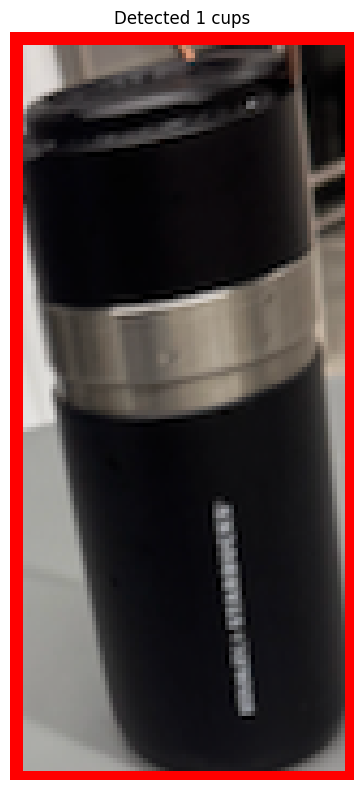


Detected 1 cups
  Cup 1: bottle (conf: 0.62)


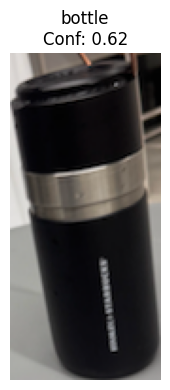

In [5]:
# 샘플 이미지 선택
sample_images = []
for cup_code_dir in sorted(DATA_DIR.iterdir()):
    if cup_code_dir.is_dir():
        images = list(cup_code_dir.glob('*.jpg')) + list(cup_code_dir.glob('*.png'))
        if len(images) > 0:
            sample_images.append(images[0])

print(f"Found {len(sample_images)} sample images (1 per cup_code)")

# 첫 번째 샘플 테스트
if len(sample_images) > 0:
    test_image = sample_images[0]
    print(f"\nTesting with: {test_image}")
    
    cropped_images, detections = detect_and_crop_cup(
        image_path=test_image,
        model=model,
        conf_thresh=CONFIDENCE_THRESHOLD,
        iou_thresh=IOU_THRESHOLD,
        target_classes=TARGET_CLASSES,
        padding=CROP_PADDING,
        min_size=MIN_CROP_SIZE,
        visualize=True
    )
    
    print(f"\nDetected {len(detections)} cups")
    for i, det in enumerate(detections):
        print(f"  Cup {i+1}: {det['class_name']} (conf: {det['confidence']:.2f})")
    
    if len(cropped_images) > 0:
        show_crops(cropped_images, detections)
else:
    print("No sample images found")

## 6. 여러 샘플 테스트

Testing 5 samples...


Sample 1/5: black_starbucks/zf_bottle_14.png


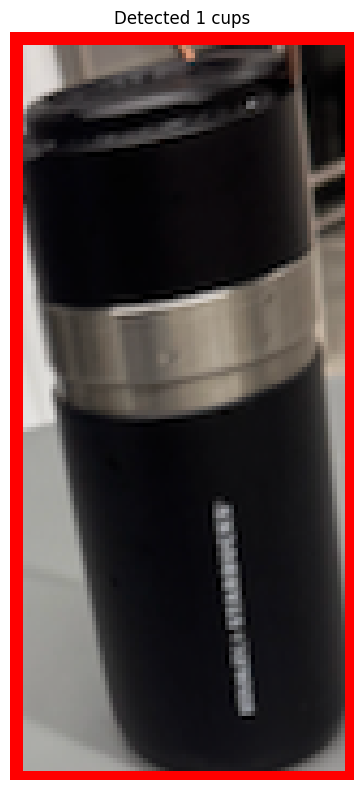

✓ Detected 1 cups


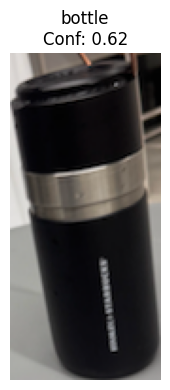


Sample 2/5: mug_cup/zf_bottle_217.png


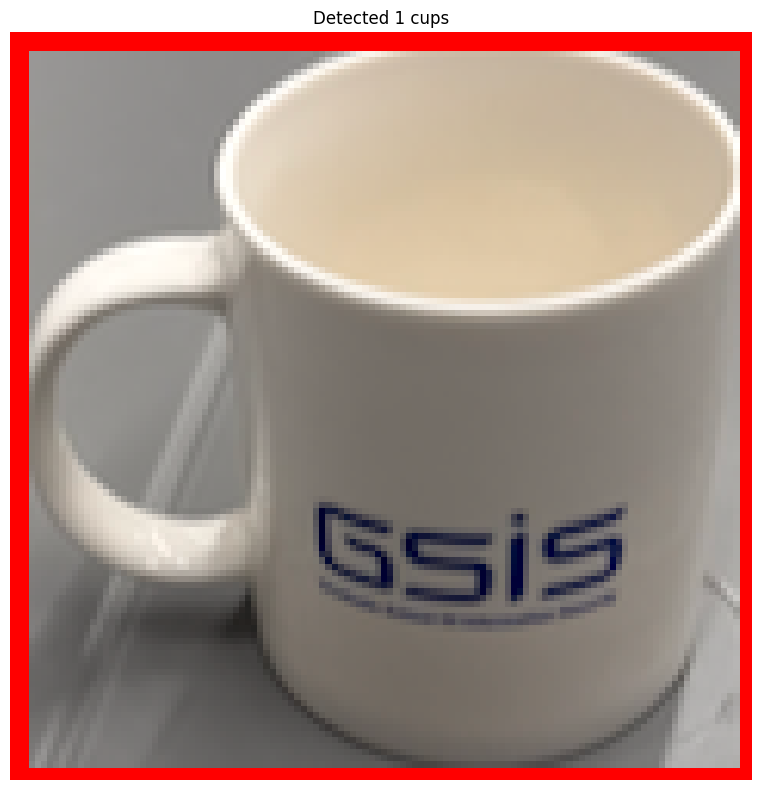

✓ Detected 1 cups


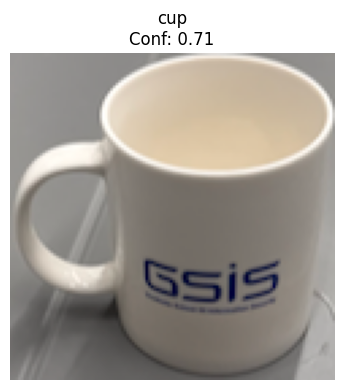


Sample 3/5: paper_cup/zf_bottle_194.png
⚠️  No cups detected

Sample 4/5: steel_cup/zf_bottle_232.png
⚠️  No cups detected

Sample 5/5: togo_dome/zf_bottle_315.png


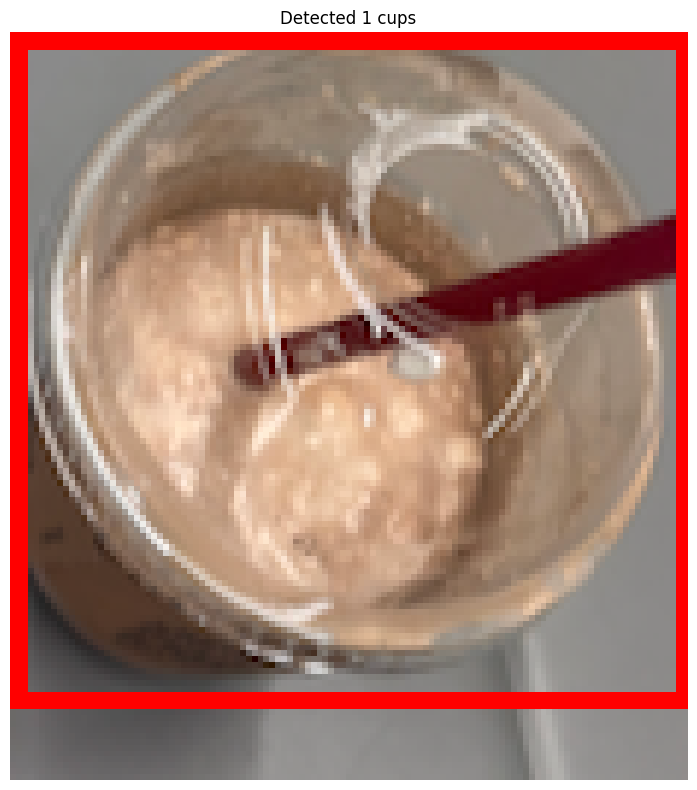

✓ Detected 1 cups


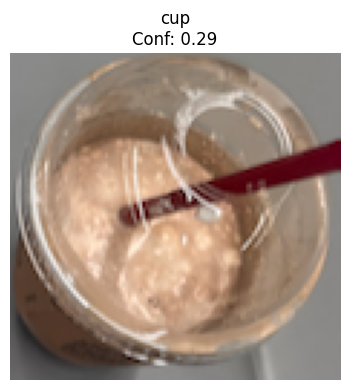

In [6]:
# 여러 샘플 테스트
n_samples = min(5, len(sample_images))

print(f"Testing {n_samples} samples...\n")

for i, img_path in enumerate(sample_images[:n_samples]):
    print(f"\n{'='*60}")
    print(f"Sample {i+1}/{n_samples}: {img_path.parent.name}/{img_path.name}")
    print('='*60)
    
    cropped_images, detections = detect_and_crop_cup(
        image_path=img_path,
        model=model,
        conf_thresh=CONFIDENCE_THRESHOLD,
        iou_thresh=IOU_THRESHOLD,
        target_classes=TARGET_CLASSES,
        padding=CROP_PADDING,
        min_size=MIN_CROP_SIZE,
        visualize=True
    )
    
    if len(detections) == 0:
        print("⚠️  No cups detected")
    else:
        print(f"✓ Detected {len(detections)} cups")
        show_crops(cropped_images, detections)

## 7. 전체 데이터셋 처리 및 저장

In [7]:
def process_dataset(data_dir, output_dir, model, conf_thresh, iou_thresh, 
                   target_classes, padding, min_size):
    """
    전체 데이터셋 처리 및 저장
    """
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    
    stats = {
        'total_images': 0,
        'images_with_detection': 0,
        'total_crops': 0,
        'no_detection': [],
        'multiple_detections': []
    }
    
    # Cup code별 디렉토리 순회
    for cup_code_dir in sorted(data_dir.iterdir()):
        if not cup_code_dir.is_dir():
            continue
        
        cup_code = cup_code_dir.name
        print(f"\nProcessing {cup_code}...")
        
        # 출력 디렉토리 생성
        cup_output_dir = output_dir / cup_code
        cup_output_dir.mkdir(parents=True, exist_ok=True)
        
        # 이미지 파일 수집
        image_files = list(cup_code_dir.glob('*.jpg')) + list(cup_code_dir.glob('*.png'))
        
        for img_path in tqdm(image_files, desc=f"  {cup_code}"):
            stats['total_images'] += 1
            
            # 감지 및 cropping
            cropped_images, detections = detect_and_crop_cup(
                image_path=img_path,
                model=model,
                conf_thresh=conf_thresh,
                iou_thresh=iou_thresh,
                target_classes=target_classes,
                padding=padding,
                min_size=min_size,
                visualize=False
            )
            
            if len(cropped_images) == 0:
                # 감지 실패 - 원본 이미지 저장
                stats['no_detection'].append(str(img_path))
                original = Image.open(img_path).convert('RGB')
                output_path = cup_output_dir / img_path.name
                original.save(output_path)
            else:
                stats['images_with_detection'] += 1
                
                if len(cropped_images) > 1:
                    stats['multiple_detections'].append((str(img_path), len(cropped_images)))
                
                # Cropped 이미지 저장
                for i, crop in enumerate(cropped_images):
                    stats['total_crops'] += 1
                    
                    # 파일명: original_name_crop_0.jpg
                    stem = img_path.stem
                    ext = img_path.suffix
                    output_name = f"{stem}_crop_{i}{ext}"
                    output_path = cup_output_dir / output_name
                    
                    crop.save(output_path)
    
    return stats

print("✓ Dataset processing function defined")

✓ Dataset processing function defined


In [8]:
# 전체 데이터셋 처리
print(f"Processing entire dataset...\n")
print(f"Input:  {DATA_DIR}")
print(f"Output: {OUTPUT_DIR}")
print()

stats = process_dataset(
    data_dir=DATA_DIR,
    output_dir=OUTPUT_DIR,
    model=model,
    conf_thresh=CONFIDENCE_THRESHOLD,
    iou_thresh=IOU_THRESHOLD,
    target_classes=TARGET_CLASSES,
    padding=CROP_PADDING,
    min_size=MIN_CROP_SIZE
)

# 통계 출력
print(f"\n{'='*60}")
print("Processing Statistics")
print('='*60)
print(f"Total images processed: {stats['total_images']}")
print(f"Images with detection: {stats['images_with_detection']} ({stats['images_with_detection']/stats['total_images']*100:.1f}%)")
print(f"Total crops generated: {stats['total_crops']}")
print(f"Images with no detection: {len(stats['no_detection'])}")
print(f"Images with multiple detections: {len(stats['multiple_detections'])}")

if len(stats['no_detection']) > 0:
    print(f"\n⚠️  Images with no detection:")
    for path in stats['no_detection'][:10]:  # Show first 10
        print(f"  - {path}")
    if len(stats['no_detection']) > 10:
        print(f"  ... and {len(stats['no_detection']) - 10} more")

if len(stats['multiple_detections']) > 0:
    print(f"\nℹ️  Images with multiple detections:")
    for path, count in stats['multiple_detections'][:10]:  # Show first 10
        print(f"  - {path}: {count} cups")
    if len(stats['multiple_detections']) > 10:
        print(f"  ... and {len(stats['multiple_detections']) - 10} more")

print(f"\n✓ Cropped images saved to: {OUTPUT_DIR}")

Processing entire dataset...

Input:  data/dataset_20251110_141636/types
Output: data/cropped_cups


Processing black_starbucks...


  black_starbucks: 100%|██████████| 21/21 [00:01<00:00, 15.51it/s]



Processing mug_cup...


  mug_cup: 100%|██████████| 29/29 [00:02<00:00, 13.82it/s]



Processing paper_cup...


  paper_cup: 100%|██████████| 19/19 [00:01<00:00, 13.32it/s]



Processing steel_cup...


  steel_cup: 100%|██████████| 22/22 [00:01<00:00, 14.25it/s]



Processing togo_dome...


  togo_dome: 100%|██████████| 19/19 [00:01<00:00, 14.81it/s]



Processing togo_flat...


  togo_flat: 100%|██████████| 39/39 [00:02<00:00, 15.36it/s]



Processing u_turn_cup...


  u_turn_cup: 100%|██████████| 69/69 [00:05<00:00, 13.57it/s]


Processing Statistics
Total images processed: 218
Images with detection: 78 (35.8%)
Total crops generated: 81
Images with no detection: 140
Images with multiple detections: 3

⚠️  Images with no detection:
  - data/dataset_20251110_141636/types/black_starbucks/zf_bottle_10.png
  - data/dataset_20251110_141636/types/black_starbucks/zf_bottle_25.png
  - data/dataset_20251110_141636/types/black_starbucks/zf_bottle_22.png
  - data/dataset_20251110_141636/types/black_starbucks/zf_bottle_17.png
  - data/dataset_20251110_141636/types/black_starbucks/zf_bottle_26.png
  - data/dataset_20251110_141636/types/black_starbucks/zf_bottle_16.png
  - data/dataset_20251110_141636/types/black_starbucks/zf_bottle_101.png
  - data/dataset_20251110_141636/types/black_starbucks/zf_bottle_21.png
  - data/dataset_20251110_141636/types/black_starbucks/zf_bottle_12.png
  - data/dataset_20251110_141636/types/black_starbucks/zf_bottle_23.png
  ... and 130 more

ℹ️  Images with multiple detections:
  - data/datase

## 8. Cropped 이미지로 Siamese Network 학습

이제 cropped 이미지로 Siamese Network를 재학습할 수 있습니다.

In [ ]:
# Siamese Network 재학습 안내
print("다음 단계: Cropped 이미지로 Siamese Network 재학습")
print("="*60)
print()
print("04_siamese_network_training.ipynb를 다시 실행하되,")
print("DATA_DIR을 다음으로 변경하세요:")
print()
print(f"  DATA_DIR = '{OUTPUT_DIR}'")
print()
print("배경이 제거된 cropped 이미지로 학습하면:")
print("  ✓ Intra-class distance 감소 (같은 컵끼리 더 유사)")
print("  ✓ Inter-class distance 증가 (다른 컵끼리 더 차이)")
print("  ✓ 임베딩 품질 향상")
print("  ✓ 실전 성능 개선")

## 9. 통합 파이프라인 함수

실제 서비스에서 사용할 수 있는 통합 파이프라인 함수입니다.

In [ ]:
def cup_detection_pipeline(image_path, yolo_model, siamese_model=None, 
                          conf_thresh=0.25, visualize=False):
    """
    컵 감지 → Cropping → 임베딩 생성 파이프라인
    
    Args:
        image_path: 입력 이미지 경로
        yolo_model: YOLO 모델 (cup detection)
        siamese_model: Siamese Network (embedding generation, optional)
        conf_thresh: YOLO 신뢰도 임계값
        visualize: 시각화 여부
    
    Returns:
        results: {
            'detections': list of detection dicts,
            'cropped_images': list of PIL Images,
            'embeddings': list of embeddings (if siamese_model provided)
        }
    """
    # Step 1: Object Detection
    cropped_images, detections = detect_and_crop_cup(
        image_path=image_path,
        model=yolo_model,
        conf_thresh=conf_thresh,
        iou_thresh=IOU_THRESHOLD,
        target_classes=TARGET_CLASSES,
        padding=CROP_PADDING,
        min_size=MIN_CROP_SIZE,
        visualize=visualize
    )
    
    results = {
        'detections': detections,
        'cropped_images': cropped_images,
        'embeddings': None
    }
    
    # Step 2: Embedding Generation (optional)
    if siamese_model is not None and len(cropped_images) > 0:
        from torchvision import transforms
        
        # Transform for Siamese Network
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
        embeddings = []
        for crop in cropped_images:
            img_tensor = transform(crop).unsqueeze(0).to(device)
            
            with torch.no_grad():
                embedding = siamese_model(img_tensor)
                embeddings.append(embedding.cpu().numpy()[0])
        
        results['embeddings'] = embeddings
    
    return results

print("✓ Integrated pipeline function defined")

## 10. 통합 파이프라인 테스트 (Siamese Network 포함)

In [ ]:
# Siamese Network 로드 (이미 학습된 모델이 있는 경우)
try:
    from models.siamese_network import SiameseNetwork
    
    siamese_model_path = MODEL_SAVE_DIR / 'siamese_network.pth'
    
    if siamese_model_path.exists():
        print(f"Loading Siamese Network from {siamese_model_path}...")
        
        # 모델 초기화
        siamese_model = SiameseNetwork(embedding_dim=256).to(device)
        
        # 체크포인트 로드
        checkpoint = torch.load(siamese_model_path, map_location=device)
        siamese_model.load_state_dict(checkpoint['model_state_dict'])
        siamese_model.eval()
        
        print("✓ Siamese Network loaded")
        
        # 테스트
        if len(sample_images) > 0:
            test_image = sample_images[0]
            print(f"\nTesting pipeline with: {test_image}")
            
            results = cup_detection_pipeline(
                image_path=test_image,
                yolo_model=model,
                siamese_model=siamese_model,
                conf_thresh=CONFIDENCE_THRESHOLD,
                visualize=True
            )
            
            print(f"\nPipeline Results:")
            print(f"  Detections: {len(results['detections'])}")
            print(f"  Cropped images: {len(results['cropped_images'])}")
            
            if results['embeddings'] is not None:
                print(f"  Embeddings: {len(results['embeddings'])}")
                for i, emb in enumerate(results['embeddings']):
                    print(f"    - Embedding {i+1} shape: {emb.shape}")
                    print(f"      L2 norm: {np.linalg.norm(emb):.4f}")
            
            show_crops(results['cropped_images'], results['detections'])
    else:
        print(f"Siamese model not found at {siamese_model_path}")
        print("Run 04_siamese_network_training.ipynb first to train the model")
        siamese_model = None

except Exception as e:
    print(f"Could not load Siamese Network: {e}")
    siamese_model = None

## 11. 요약 및 다음 단계

### 구현 내용
1. ✅ YOLOv8을 사용한 컵 영역 감지
2. ✅ 감지된 영역 cropping 및 저장
3. ✅ 전체 데이터셋 일괄 처리
4. ✅ Siamese Network와 통합 파이프라인

### 장점
- 배경 noise 제거로 임베딩 품질 향상
- 컵 영역에만 집중하여 특징 추출
- 실전 환경에서 더 robust한 성능

### 다음 단계
1. **Cropped 이미지로 Siamese Network 재학습**
   - `04_siamese_network_training.ipynb`에서 `DATA_DIR` 변경
   - 성능 비교 (원본 vs cropped)

2. **FastAPI 서버 통합**
   ```python
   # /api/detect-and-embed 엔드포인트
   1. YOLO로 컵 감지
   2. Cropping
   3. Siamese Network로 임베딩 생성
   4. 데이터베이스와 비교
   ```

3. **Custom YOLO 학습 (선택사항)**
   - 컵 데이터셋으로 fine-tuning
   - 더 높은 정확도 달성

4. **성능 최적화**
   - YOLO 모델 경량화 (YOLOv8n)
   - 추론 속도 개선
   - GPU 메모리 최적화

## 부록: YOLO Custom Training 가이드

만약 COCO 모델의 성능이 충분하지 않다면, 컵 데이터셋으로 custom training을 수행할 수 있습니다.

```python
# 1. 데이터셋 준비 (YOLO 형식)
# dataset/
#   images/
#     train/
#     val/
#   labels/
#     train/
#     val/
#   data.yaml

# 2. data.yaml 작성
# path: ./dataset
# train: images/train
# val: images/val
# nc: 1  # number of classes
# names: ['cup']

# 3. 학습
from ultralytics import YOLO

model = YOLO('yolov8n.pt')
results = model.train(
    data='dataset/data.yaml',
    epochs=100,
    imgsz=640,
    batch=16,
    device=0
)
```

Label Studio를 사용하여 annotation을 수행할 수 있습니다.